In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


In [2]:
data = pd.read_csv('BTCUSDT_1m.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [3]:
def trend_following_strategy(data, short_window=20, long_window=50):
    data['SMA_short'] = data['close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    data['position'] = np.where(data['SMA_short'] > data['SMA_long'], 1, -1)
    data.dropna(inplace=True)
    return data['position']

In [4]:
def mean_reversion_strategy(data, window=20, num_std_dev=2):
    data['rolling_mean'] = data['close'].rolling(window=window).mean()
    data['rolling_std'] = data['close'].rolling(window=window).std()
    data['upper_band'] = data['rolling_mean'] + num_std_dev * data['rolling_std']
    data['lower_band'] = data['rolling_mean'] - num_std_dev * data['rolling_std']
    data['position'] = np.where(data['close'] < data['lower_band'], 1, 
                                np.where(data['close'] > data['upper_band'], -1, 0))
    data.dropna(inplace=True)
    return data['position']

In [5]:
def momentum_strategy(data, window=14, upper=70, lower=30):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['position'] = np.where(data['RSI'] < lower, 1, 
                                np.where(data['RSI'] > upper, -1, 0))
    data.dropna(inplace=True)
    return data['position']

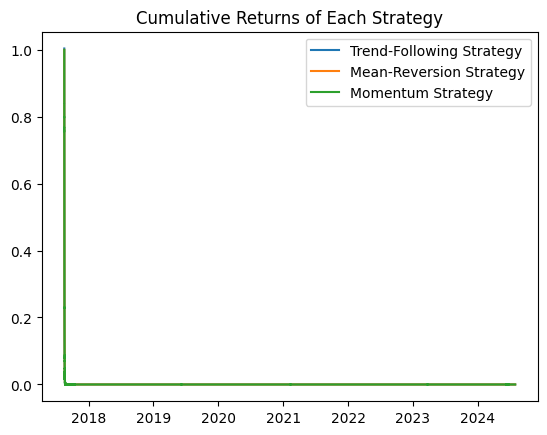

,Sharpe Ratio,Sortino Ratio,Max Drawdown,Annualized Return,Cumulative Return
Trend-Following,-12.970852,-17.255297,-1.0,-0.252534,-1.0
Mean-Reversion,-29.133242,-39.590127,-1.0,-0.250399,-1.0
Momentum,-22.528474,-30.641514,-1.0,-0.249810,-1.0


In [7]:
def backtest(data, strategy_position, transaction_cost=0.001):

    data['returns'] = data['close'].pct_change()
    data['strategy_returns'] = data['returns'] * strategy_position.shift(1) - transaction_cost
    data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod()
    
 
    sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std() * np.sqrt(252)
    sortino_ratio = data['strategy_returns'].mean() / data[data['strategy_returns'] < 0]['strategy_returns'].std() * np.sqrt(252)
    max_drawdown = (data['cumulative_returns'] / data['cumulative_returns'].cummax() - 1).min()
    annual_return = data['strategy_returns'].mean() * 252
    cumulative_return = data['cumulative_returns'].iloc[-1] - 1
    
    results = {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Annualized Return': annual_return,
        'Cumulative Return': cumulative_return
    }
    
    return results, data[['returns', 'strategy_returns', 'cumulative_returns']]

strategies = {
    'Trend-Following': trend_following_strategy(data.copy()),
    'Mean-Reversion': mean_reversion_strategy(data.copy()),
    'Momentum': momentum_strategy(data.copy())
}

results = {}
for name, strategy_position in strategies.items():
    res, strat_data = backtest(data.copy(), strategy_position)
    results[name] = res
    plt.plot(strat_data['cumulative_returns'], label=f"{name} Strategy")
plt.legend()
plt.title("Cumulative Returns of Each Strategy")
plt.show()


results_df = pd.DataFrame(results).T
results_df

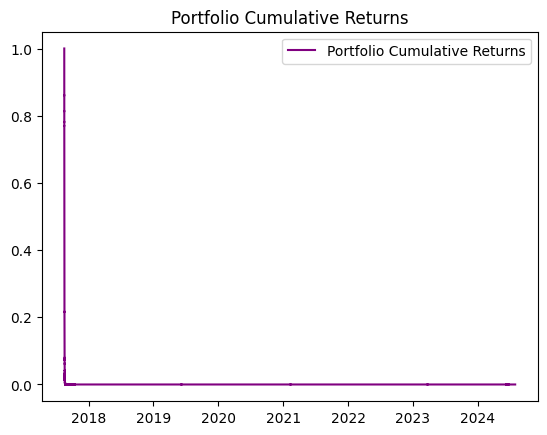

In [8]:
data['portfolio_position'] = (strategies['Trend-Following'] + strategies['Mean-Reversion'] + strategies['Momentum']) / 3
portfolio_results, portfolio_data = backtest(data.copy(), data['portfolio_position'])
plt.plot(portfolio_data['cumulative_returns'], label="Portfolio Cumulative Returns", color='purple')
plt.legend()
plt.title("Portfolio Cumulative Returns")
plt.show()

In [9]:
trade_log = data[data['portfolio_position'].diff() != 0][['close', 'portfolio_position']]
trade_log['P&L'] = trade_log['close'].diff() * trade_log['portfolio_position']
trade_log

,close,portfolio_position,P&L
timestamp,,,
2017-08-17 04:00:00,4261.48,NaN,NaN
2017-08-17 04:01:00,4261.48,NaN,NaN
2017-08-17 04:02:00,4280.56,NaN,NaN
2017-08-17 04:03:00,4261.48,NaN,NaN
2017-08-17 04:04:00,4261.48,NaN,NaN
...,...,...,...
2024-07-29 23:36:00,66912.00,-0.333333,31.343333
2024-07-29 23:41:00,66854.01,0.000000,-0.000000
2024-07-29 23:42:00,66820.00,0.333333,-11.336667


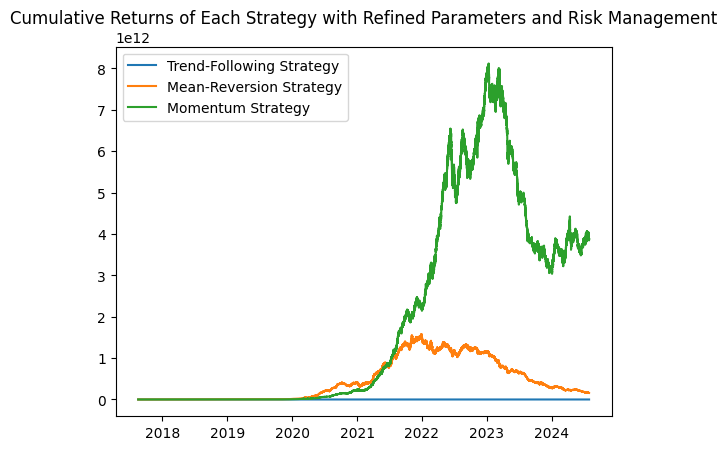

,Sharpe Ratio,Sortino Ratio,Max Drawdown,Annualized Return,Cumulative Return
Trend-Following,-0.047052,-0.062101,-0.999900,-0.000553,-9.998779e-01
Mean-Reversion,0.220996,0.166369,-0.901386,0.001815,1.573882e+11
Momentum,0.221305,0.199491,-0.626043,0.002046,3.872193e+12


In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


data = pd.read_csv('BTCUSDT_1m.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

def apply_risk_management(data, position, stop_loss=0.01, take_profit=0.03):
    data['strategy_returns'] = data['returns'] * position.shift(1)
    
    
    data['strategy_returns'] = np.where(data['strategy_returns'] < -stop_loss, -stop_loss,
                                        np.where(data['strategy_returns'] > take_profit, take_profit,
                                                 data['strategy_returns']))
    
    
    data['cum_returns'] = (1 + data['strategy_returns']).cumprod()
    return data



# 1. Trend-Following Strategy
def trend_following_strategy(data, short_window=10, long_window=40):
    data['SMA_short'] = data['close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    data['position'] = np.where(data['SMA_short'] > data['SMA_long'], 1, -1)
    data.dropna(inplace=True)
    return data['position']

# 2. Mean-Reversion Strategy with tighter Bollinger Bands
def mean_reversion_strategy(data, window=15, num_std_dev=1.2):
    data['rolling_mean'] = data['close'].rolling(window=window).mean()
    data['rolling_std'] = data['close'].rolling(window=window).std()
    data['upper_band'] = data['rolling_mean'] + num_std_dev * data['rolling_std']
    data['lower_band'] = data['rolling_mean'] - num_std_dev * data['rolling_std']
    data['position'] = np.where(data['close'] < data['lower_band'], 1,
                                np.where(data['close'] > data['upper_band'], -1, 0))
    data.dropna(inplace=True)
    return data['position']

# 3. Momentum Strategy with adjusted RSI thresholds
def momentum_strategy(data, window=14, upper=60, lower=40):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['position'] = np.where(data['RSI'] < lower, 1, np.where(data['RSI'] > upper, -1, 0))
    data.dropna(inplace=True)
    return data['position']

# Backtesting function with volatility-based position sizing
def backtest(data, strategy_func, stop_loss=0.01, take_profit=0.03):
    
    data['returns'] = data['close'].pct_change()

    position = strategy_func(data)
    
   
    data['volatility'] = data['returns'].rolling(window=20).std()
    position *= np.where(data['volatility'] < data['volatility'].mean(), 1, 0.5)
    

    data = apply_risk_management(data, position, stop_loss, take_profit)
    

    sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std() * np.sqrt(252)
    sortino_ratio = data['strategy_returns'].mean() / data[data['strategy_returns'] < 0]['strategy_returns'].std() * np.sqrt(252)
    max_drawdown = (data['cum_returns'] / data['cum_returns'].cummax() - 1).min()
    annual_return = data['strategy_returns'].mean() * 252
    cumulative_return = data['cum_returns'].iloc[-1] - 1

    results = {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Annualized Return': annual_return,
        'Cumulative Return': cumulative_return
    }
    
    return results, data[['returns', 'strategy_returns', 'cum_returns']]


strategies = {
    'Trend-Following': trend_following_strategy,
    'Mean-Reversion': mean_reversion_strategy,
    'Momentum': momentum_strategy
}


results = {}
for name, strategy_func in strategies.items():
    res, strat_data = backtest(data.copy(), strategy_func)
    results[name] = res
    plt.plot(strat_data['cum_returns'], label=f"{name} Strategy")

plt.legend()
plt.title("Cumulative Returns of Each Strategy with Refined Parameters and Risk Management")
plt.show()


results_df = pd.DataFrame(results).T
results_df